In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary

from tqdm.auto import tqdm
import pyLDAvis.gensim_models

In [2]:
def compute_coherence_values(id2word, corpus, topics_range=range(2, 100, 5)):
    coherence_values = []

    for num_topics in tqdm(topics_range):        
        model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

# Task

> Ответить на два следующих вопроса (хотя бы попытаться):
>
>1. Каковы основные причины для обращений в релизе 2020.2?
>2. Какие новые проблемы добавились в релизе 2020.3 и какие ушли, по сравнению с релизом 2020.2?

# Data preparation

In [3]:
data = pd.read_json('data/pycharm_issues.json', lines=True) \
        .rename(columns={"Affected versions": "affected_versions"}) \
        .dropna()
data = data[data.affected_versions.apply(
    lambda v: len(set(v).intersection({"2020.2", "2020.3", "2021.1", "2021.2", "2021.3"}))) > 0]

In [4]:
vectorizer = CountVectorizer(
    stop_words="english", 
    ngram_range=(1, 4),
    min_df=0.001,
    max_df=0.999,
)
vec_data = vectorizer.fit_transform(data["summary"])

corpus = Sparse2Corpus(vec_data, documents_columns=False)

id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
word2id = dict((k, v) for k, v in vectorizer.vocabulary_.items())

dictionary = Dictionary()
dictionary.id2token = id2word
dictionary.token2id = word2id

# Optimal* number of topics

\* ну почти оптимальное, в том смысле, что оно максимизирует какую-то coherence метрику, в данном случае u_mass (чем больше, тем лучше)

In [5]:
topics_range = range(2, 500, 10)
u_mass = compute_coherence_values(id2word, corpus, topics_range=topics_range)

  0%|          | 0/50 [00:00<?, ?it/s]

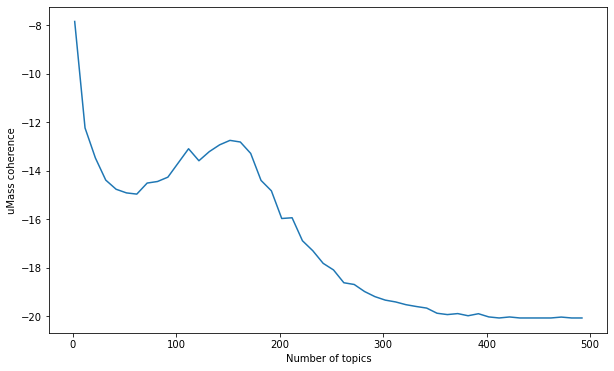

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(topics_range, u_mass)
plt.xlabel("Number of topics")
plt.ylabel("uMass coherence");

Оптимальное количество где-то в районе 120-160 топиков. Конкретное количество я подобрал по визуализации, чтобы не было кучи маленьких топиков в центре без весомых слов (это конечно валидно только для этих параметров и этого `random_state=100`).

# LDA model on summaries for last 5 versions

In [8]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=120, 
    random_state=100,
)

In [11]:
pyLDAvis.enable_notebook()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=dictionary, mds='mmds')

In [12]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
83     0.051508 -0.346841       1        1  1.461080
74     0.150917 -0.325237       2        1  1.408540
108    0.472349 -0.070907       3        1  1.396093
93     0.026465 -0.486438       4        1  1.338976
29    -0.480175  0.050702       5        1  1.336408
...         ...       ...     ...      ...       ...
48    -0.020556  0.057450     116        1  0.495779
80     0.165600  0.196488     117        1  0.451974
111    0.112788  0.094328     118        1  0.363647
76     0.054465  0.160304     119        1  0.344778
7      0.014666  0.037101     120        1  0.105539

[120 rows x 5 columns], topic_info=             Term        Freq       Total  Category  logprob  loglift
78           type  249.000000  249.000000   Default  30.0000  30.0000
106         false  134.000000  134.000000   Default  29.0000  29.0000
60         python  300.000000  300.000000   Default  28.0000  28.0000
210         error  142.000000  142.000000   Default  27.0000  27.0000
6         project  135.000000  135.000000   Default  26.0000  26.0000
..            ...         ...         ...       ...      ...      ...
24     powershell    0.010953    1.498583  Topic120  -7.3278   1.9352
25         prompt    0.010953    1.460154  Topic120  -7.3278   1.9612
26   requirements    0.010953   21.206754  Topic120  -7.3278  -0.7146
27       detected    0.010953   13.385364  Topic120  -7.3278  -0.2544
28          setup    0.010953    9.121580  Topic120  -7.3278   0.1291

[5110 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
731      22  0.014835     10
731      27  0.103848     10
731      41  0.029671     10
731      43  0.014835     10
731      60  0.178025     10
...     ...       ...    ...
498     112  0.861216    xml
1385     15  0.083317   yaml
1385     54  0.499902   yaml
1385     78  0.333268   yaml
134     100  0.833142  yield

[2947 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[84, 75, 109, 94, 30, 23, 31, 66, 53, 62, 115, 64, 25, 110, 97, 67, 10, 92, 36, 74, 105, 17, 65, 18, 26, 68, 21, 6, 114, 90, 14, 119, 113, 96, 61, 111, 40, 44, 93, 59, 48, 80, 87, 91, 102, 95, 46, 88, 13, 83, 20, 22, 41, 78, 60, 57, 56, 85, 117, 82, 24, 4, 28, 9, 86, 5, 98, 116, 107, 106, 39, 70, 1, 34, 32, 3, 100, 16, 120, 51, 50, 63, 11, 103, 89, 55, 72, 29, 73, 12, 118, 108, 69, 58, 42, 104, 54, 38, 19, 35, 43, 76, 37, 7, 99, 33, 79, 47, 71, 15, 52, 45, 2, 27, 101, 49, 81, 112, 77, 8])

In [26]:
pyLDAvis.save_html(vis, "lda.html")

# Most important topics for 2020.2 & 2020.3 version

Смотреть на самый доминатный топик - очень большое допущение, которое я бы не стал делать в проде по очевидным причинам. В домашке я думаю это должно быть ок.

In [13]:
def most_important_topic(lda_model, corpus):
    topics = []
    
    for i, row_list in enumerate(lda_model[corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list            
        
        if len(row) == 0:
            topics.append(-1)
            continue
        
        row = sorted(row, key=lambda x: x[1], reverse=True)

        topic_num, topic_prop = row[0]
        topics.append(topic_num + 1)
    
    return topics

In [14]:
data["dominant_topic"] = most_important_topic(lda_model, corpus)

data_2020_2 = data[data.affected_versions.apply(lambda v: "2020.2" in v and len(v) == 1)]
data_2020_3 = data[data.affected_versions.apply(lambda v: "2020.3" in v and len(v) == 1)]

topics_2020_2 = data_2020_2["dominant_topic"].value_counts()
topics_2020_3 = data_2020_3["dominant_topic"].value_counts()

Вначале посмотрим на самые частые топики для версии 2020.2

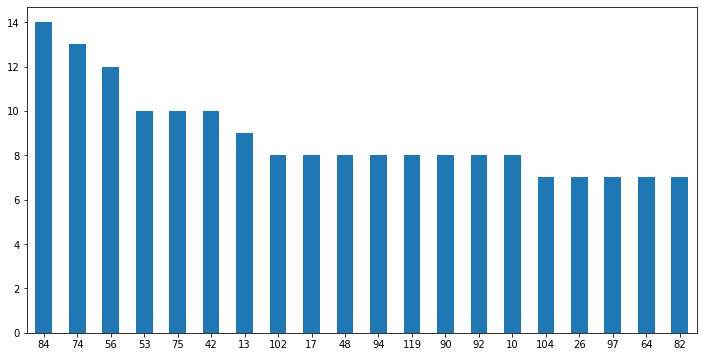

In [15]:
plt.figure(figsize=(12, 6))
topics_2020_2[:20].plot(kind="bar", rot=0);

## Изменение общих темы для версий 2020.2 и 2020.3 

In [16]:
common = set(data_2020_3["dominant_topic"].values).intersection(set(data_2020_2["dominant_topic"].values))

In [23]:
versions_diff = (
    topics_2020_2[topics_2020_2.index.isin(common)].sort_index() -
    topics_2020_3[topics_2020_3.index.isin(common)].sort_index()
).sort_values(key=abs)[-20:]

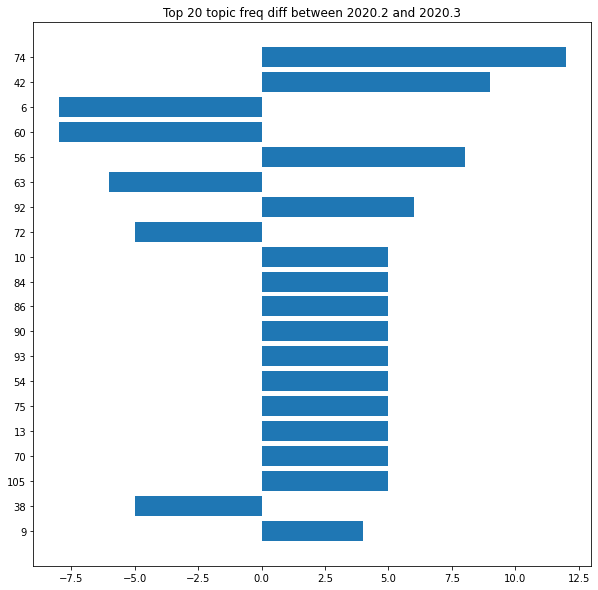

In [25]:
x = np.arange(len(versions_diff.index))

plt.figure(figsize=(10, 10))
plt.barh(x, versions_diff.values)
plt.title("Top 20 topic freq diff between 2020.2 and 2020.3")
plt.yticks(ticks=x, labels=versions_diff.index);

## Какие новые темы появилсь в версии 2020.3?

In [19]:
new_topics = set(data_2020_3["dominant_topic"].values).difference(set(data_2020_2["dominant_topic"].values))
new_topics

{49, 79, 101, 118}

In [20]:
topics_2020_3[topics_2020_3.index.isin(new_topics)] # топик == индекс

79     5
118    3
49     2
101    1
Name: dominant_topic, dtype: int64

## Какие темы были в версии 2020.2, но ушли в 2020.3?

в 2020.2 явно что-то случилось с питоном

In [21]:
old_topics = set(data_2020_2["dominant_topic"].values).difference(set(data_2020_3["dominant_topic"].values))
old_topics

{1, 7, 39}

In [22]:
topics_2020_2[topics_2020_2.index.isin(old_topics)]

1     7
39    4
7     2
Name: dominant_topic, dtype: int64